This notebook is inspired from [@shivamb's notebook on text generation](https://www.kaggle.com/shivamb/beginners-guide-to-text-generation-using-lstms) and [@thebrownviking20's work on LSTMs](https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru)

The goal of this notebook is to generate TripAdvisor reviews with Long Short Term Memory units.

# LSTMs

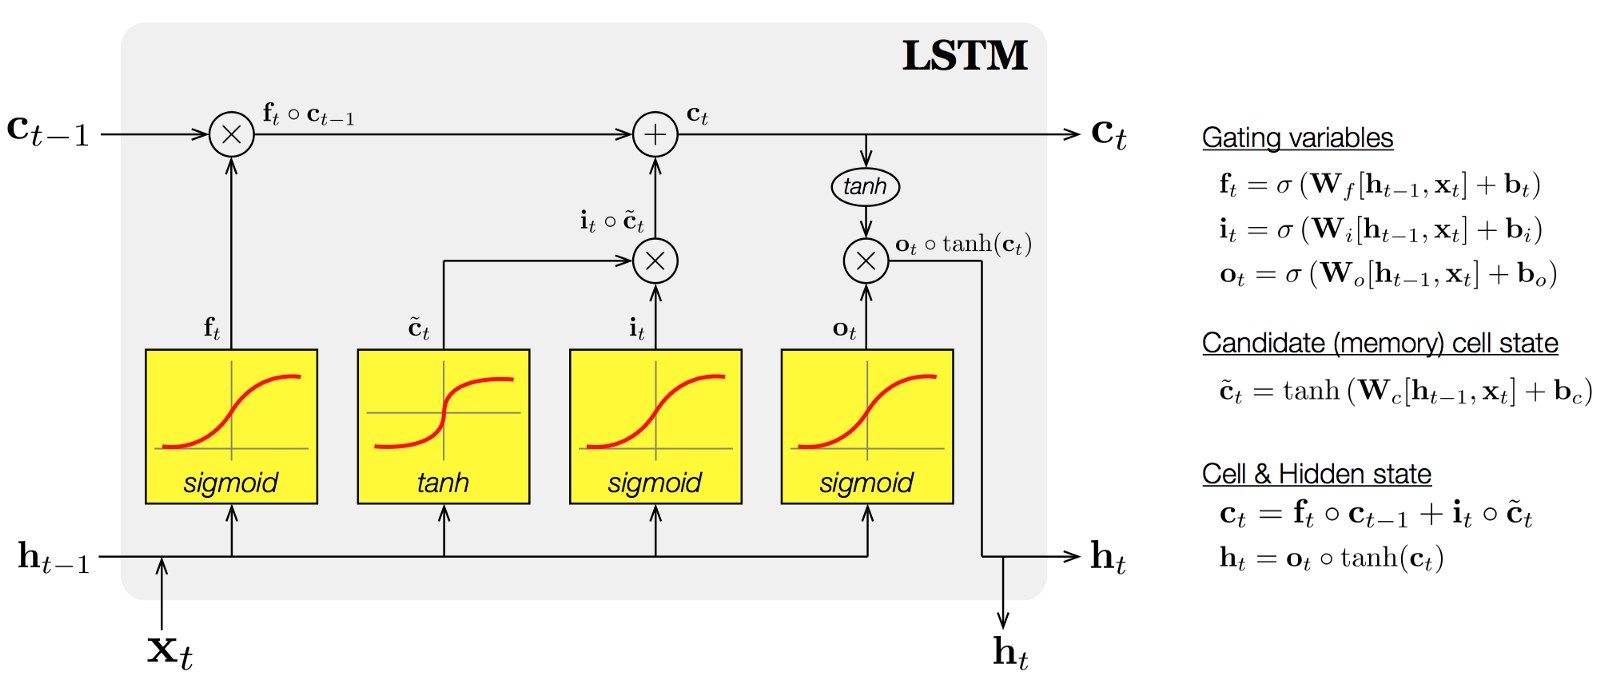

The LSTM block learns which elements it should retain over the long term and which elements it should forget. We can consider the states of the Ct memory as the states of a memory acting on the long term and we can see the hidden states ht as the states of a memory acting on the short term.

It first takes the previous memory state Ct-1 and performs a multiplication with the forget gate f to decide at which degree Ct-1 should be forgotten. The value of the forget gate is between 0 and 1. For example, if it is equal to 0, then Ct-1 is completely forgotten; and if it is equal to 1, then Ct-1 is completely passed on to the rest of the block.

It then adds the part of Ct-1 retained and the information retained by the I gate.
The Ct memory state thus obtained is transferred directly to the next LSTM block. On the other hand, Ct is copied. The tanh function is applied to this copy, then the result is coupled with xt and ht-1, and the final result obtained is filtered by the output gate O. This gives us the hidden state ht of the LSTM block, which is then transferred to the next LSTM block.

# Data preparation

The LSTMs are implemented, and the data prepared for the model thanks to the Keras library. The first step is to clean the data, by removing for example the punctuation present in the corpus.

In [ ]:
import pandas as pd
import numpy as np
import string

# keras module for building LSTM 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku

from keras.callbacks import EarlyStopping

In [ ]:
trip_advisor_data = pd.read_csv('../input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv')
trip_advisor_data = trip_advisor_data['Review']
trip_advisor_data = trip_advisor_data.iloc[:1000]

In [ ]:
def clean_text(txt):
    txt = "".join(v for v in txt if v not in string.punctuation).lower()
    txt = txt.encode("utf8").decode("ascii",'ignore')
    return txt 

corpus = [clean_text(x) for x in trip_advisor_data]
corpus[0]

The next step is tokenization. It is a process of extracting tokens from a corpus. Thus, each sequence of words is converted into a sequence of tokens.

In [ ]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert data to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(corpus)
inp_sequences[:10]

Word sequences may have different lengths. We need to pad them and equalize their lengths. We use the pad_sequence function of Keras for this purpose. To train a template to generate text, we need to create labels. So for each given word sequence, the goal is to predict the next word.

In [ ]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

# Creating and training the model

In [ ]:
early_stopping = EarlyStopping(
    monitor='loss', min_delta=0.001, patience=30, verbose=0,
    mode='min', baseline=None, restore_best_weights=True
)

In [ ]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    # Add Input Embedding Layer
    model.add(Embedding(total_words, 10, input_length=input_len))
    
    # Add Hidden Layer 1 - LSTM Layer
    model.add(LSTM(100,return_sequences=True))
    model.add(Dropout(0.1))
    
    # Add Hidden Layer 2 - LSTM Layer
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    
    # Add Output Layer
    model.add(Dense(total_words, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

model = create_model(max_sequence_len, total_words)
model.summary()

In [ ]:
model.fit(predictors, label, epochs=200, callbacks=[early_stopping], verbose=False)

# Text Generating

In [ ]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " "+output_word
    return seed_text.title()

In [ ]:
print(generate_text("this hotel", 20, model, max_sequence_len))
print(generate_text("we liked", 20, model, max_sequence_len))
print(generate_text("the place", 20, model, max_sequence_len))
print(generate_text("everything", 20, model, max_sequence_len))
print(generate_text("I think",20, model, max_sequence_len))